## Imports

In [1]:
import scipy 
from scipy.io import loadmat
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import torch
import torch.nn.functional as F
# from bvh import Bvh
from sklearn.preprocessing import StandardScaler


In [3]:
cd data/UTD_MAAD/

/home/bgu9/Fall_Detection_KD_Multimodal/data/UTD_MAAD


In [6]:
cd ..

/home/bgu9/Fall_Detection_KD_Multimodal


In [24]:
skeleton_file_path = glob.glob('data/UTD_MAAD/Skeleton/*.mat')
inertia_file_path = glob.glob('data/UTD_MAAD/Inertial/*.mat')

In [43]:
a = skeleton_file_path[2].split('/')[-1]

In [13]:
b = a.split('_')
c = ('').join(b[:-1])

In [50]:
file_map = {}
for i in range(len(inertia_file_path)):
    identity = inertia_file_path[i].split('/')[-1].split('_')[:-1]
    identity = ('').join(identity)
    file_map[identity] = i


In [51]:
a = skeleton_file_path[2].split('/')[-1]
b = a.split('_')
c = ('').join(b[:-1])

In [53]:
file_map[c]

115

In [23]:
a = kf.split(x)

In [25]:
 next_ind = next(a)

In [31]:
train_index, test_index = next(a)

In [4]:
# converting bvh to array 
def bvh2arr(file_path):
    with open(file = file_path, mode='r') as f: 
        bvh_data = Bvh(f.read())
        data = bvh_data.frames
        arr = np.array(data).astype(float)
    return arr        

In [5]:
# interpolating skeleton
def interpolate(data, new_len):
    rows, cols = data.shape
    interp_data = np.zeros((new_len, cols))
    
    #x space
    x = np.linspace(0, rows, num=new_len)
    xp = np.linspace(0, rows, num = rows)
    
    for i in range(cols):
        yp = data[:, i]
        interp_col = np.interp(x, xp, yp)
        interp_data[:,i] = interp_col
    return interp_data

### UTD MHAD Processing

In [2]:
train_skl_file_path = glob.glob('data/UTD_MAAD/train_skeleton/*.mat')


In [28]:
data.shape

(209, 6)

In [19]:
data['d_skel'].shape

(20, 3, 67)

In [17]:
file_paths = glob.glob('data/UTD_MAAD/valid_inertial/*.mat')
skl_path  = '/home/bgu9/Fall_Detection_KD_Multimodal/data/UTD_MAAD/valid_skeleton/'
act_pattern = r'(a\d+)'
pattern = r'a\d+_s\d+_t\d+'
label_pattern = r'\d+'


new_skl_len = 100
new_acc_len = 100
skl_joints = 20
skl_channel = 3

samples = len(file_paths) 
skl_dataset = np.zeros((samples, new_skl_len,skl_joints,skl_channel))
acc_dataset = np.zeros((samples, new_acc_len, skl_channel))
labels = np.zeros((samples))

for idx,path in enumerate(file_paths):
    
    #loadding numpy data from csv 
    data = loadmat(path)['d_iner'] #[time_stamps, channels]
    if np.size(data) == 0 :
        continue
    #taking the accelerometer data
#     print(acc_data.shape)
    acc_data = data[:, :3] 
    act_len = acc_data.shape[0] # time_stamps
    channel = acc_data.shape[1] # channels
    label_string = re.findall(act_pattern, path)[0] #label
    label = int(re.findall(label_pattern, label_string)[0]) -1
    
    
    #interpolation 
    x = np.linspace(1, act_len, num=new_acc_len)
    xp = np.linspace(1, act_len, num= act_len)
    interpolated_data = np.zeros((new_acc_len,channel))
    
    for i in range(channel):
        yp = acc_data[:, i]
        axis_interpolated = np.interp(x, xp, yp)
#         mean = np.mean(axis_interpolated)
#         std = np.std(axis_interpolated)
#         normalized = axis_interpolated - mean / std
        interpolated_data[:, i] = axis_interpolated
        
#     scaler.fit(interpolated_data)
#     normalized = scaler.transform(interpolated_data)
    
    ## Skeleton data loading
    desp = re.findall(pattern, file_paths[idx])[0]
    skl_file = skl_path+desp+'_skeleton.mat'
    skl_data = loadmat(skl_file)['d_skel']
    skl_len = skl_data.shape[2]
    skl_data = skl_data.reshape((skl_len, -1))
    interp_skl = interpolate(skl_data, new_len = new_skl_len).reshape((new_skl_len, skl_joints,-1))
    
    #storing data
    labels[idx] = label
    skl_dataset[idx, :, :, :] = interp_skl
    acc_dataset[idx, :, :] = interpolated_data

        

In [21]:
skl_dataset[1].shape

(100, 20, 3)

In [16]:
np.savez('utd_train100', acc_data = acc_dataset, skl_data = skl_dataset, labels = labels)

In [15]:
max(labels)

26.0

In [8]:
re.findall(pattern, train_inr_file_path[1] )

['a8_s8_t4']

In [9]:
acc_dataset.shape

(645, 100, 3)

In [10]:
train_skl_file_path[1]

'data/UTD_MAAD/train_skeleton/a11_s6_t4_skeleton.mat'

True
Creating params....
Initiating Model...
ACCELERATION Only Model!
-------------ACCELERATION-------------
Acc Frames:  150
Acc embed dim:  32
Acc depth:  4
-------------Regularization-----------
Drop Rate:  0.0
Attn drop rate:  0.0
Drop path rate:  0.2


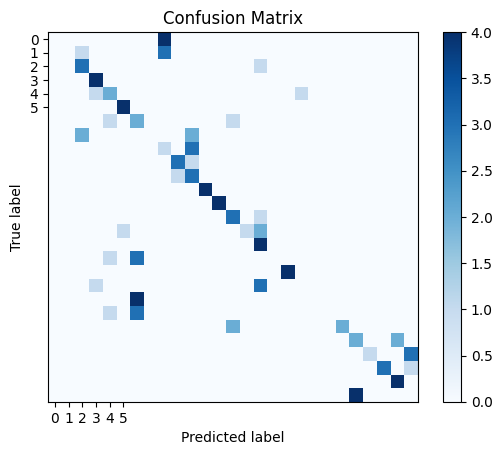

Val accuracy:   50.00 %, Val loss:   0.19777% , Val_teach:  0.00000%


In [7]:
import torch
import numpy as np
import torch.nn.functional as F
from Make_Dataset import Poses3d_Dataset, Utd_Dataset
import torch.nn as nn
import PreProcessing_ncrc
from Models.model_crossview_fusion import ActTransformerMM
from Models.model_acc_only import ActTransformerAcc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True



# Parameters
print("Creating params....")
params = {'batch_size':8,
          'shuffle': True,
          'num_workers': 0}

# Generators
#pose2id,labels,partition = PreProcessing_ncrc_losocv.preprocess_losocv(8)


dataset = 'utd'
mocap_frames = 100
acc_frames = 150
num_joints = 20
num_classes = 27

if dataset == 'ncrc':
    tr_pose2id,tr_labels,valid_pose2id,valid_labels,pose2id,labels,partition = PreProcessing_ncrc.preprocess()
    training_set = Poses3d_Dataset( data='ncrc',list_IDs=partition['train'], labels=tr_labels, pose2id=tr_pose2id, mocap_frames=mocap_frames, acc_frames=acc_frames, normalize=False)
    training_generator = torch.utils.data.DataLoader(training_set, **params) #Each produced sample is  200 x 59 x 3

    validation_set = Poses3d_Dataset(data='ncrc',list_IDs=partition['valid'], labels=valid_labels, pose2id=valid_pose2id, mocap_frames=mocap_frames, acc_frames=acc_frames ,normalize=False)
    validation_generator = torch.utils.data.DataLoader(validation_set, **params) #Each produced sample is 6000 x 229 x 3

    test_set = Poses3d_Dataset(data='ncrc',list_IDs=partition['test'], labels=labels, pose2id=pose2id, mocap_frames=mocap_frames, acc_frames=acc_frames ,normalize=False)
    test_generator = torch.utils.data.DataLoader(test_set, **params) #Each produced sample is 6000 x 229 x 3    
else:

    test_set = Utd_Dataset('/home/bgu9/Fall_Detection_KD_Multimodal/data/UTD_MAAD/valid_data.npz')
    test_generator = torch.utils.data.DataLoader(test_set, **params)


#
#Define model
print("Initiating Model...")

student_model = ActTransformerAcc(device = device, acc_frames=150, num_joints=num_joints, in_chans=3, acc_coords=3,
                                  acc_features=1, has_features=False,num_classes=num_classes)
student_model.load_state_dict(torch.load('/home/bgu9/Fall_Detection_KD_Multimodal/exps/utd/utd_utd_ckpt_wdistance.pt'))
student_model.cuda()

student_model.eval()
y_true = []
y_pred = []
val_loss = 0
val_accuracy = 0
val_t_accuracy = 0
cnt = 0.
student_model=student_model.to(device)
with torch.no_grad():
    for inputs,targets in test_generator:
        y_true.extend(targets.numpy().tolist())
        inputs = inputs.to(device); #print("Validation input: ",inputs)
        targets = targets.to(device)
        
        
        out, student_logits,predictions = student_model(inputs.float())
        loss_score = F.cross_entropy(predictions, targets)
        y_pred.extend(torch.argmax(predictions, 1).cpu().numpy().tolist())
        with torch.no_grad():
            val_loss += loss_score.sum().item()
            val_accuracy += (torch.argmax(predictions, 1) == targets).sum().item()

        cnt += len(targets)
    val_loss /= cnt
    val_accuracy *= 100. / cnt


# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(6))
plt.yticks(np.arange(6))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()
print(f"Val accuracy:  {val_accuracy:6.2f} %, Val loss:  {val_loss:8.5f}% , Val_teach: {val_t_accuracy:8.5f}%")

### Berkley Mhad Processing

In [117]:
cd '/Users/tousif/Lstm_transformer/Fall_Detection_KD_Multimodal'


/Users/tousif/Lstm_transformer/Fall_Detection_KD_Multimodal


In [118]:
file_paths = glob.glob('data/sensor/Accelerometer/Shimmer01/*')
skl_path = "/Users/tousif/Lstm_transformer/Fall_Detection_KD_Multimodal/data/sensor/SkeletalData/skl_"

In [121]:
total_sample = len(file_paths)
training_samples = round(total_sample*.7)
training_files = file_paths[:training_samples]
val_files = file_paths[training_samples:]

train_acc_dataset = np.zeros((training_samples,256, 3))
val_acc_dataset = np.zeros((total_sample-training_samples,256,3))

train_skl_dataset = np.zeros((training_samples,600,31, 3))
val_skl_dataset = np.zeros((total_sample-training_samples,600,31,3))

train_labels = np.zeros((training_samples))
val_labels = np.zeros((total_sample-training_samples))

In [122]:
label_pattern = r'(a\d+)'
pattern = r's\d+_a\d+_r\d+'
new_skl_len = 600
skl_joints = 31

for idx,path in enumerate(file_paths):
    
    #loadding numpy data from csv 
    data = np.genfromtxt(path)
    if np.size(data) == 0 :
        continue
    #taking the accelerometer data
#     print(acc_data.shape)
    acc_data = data[:, :3] 
    act_len = acc_data.shape[0]
    channel = acc_data.shape[1]
    label = int(re.findall(label_pattern, path)[0][-2:])
    
    
    #interpolation 
    x = np.linspace(1, act_len, num=256)
    xp = np.linspace(1, act_len, num= act_len)
    interpolated_data = np.zeros((256,channel))
    
    for i in range(channel):
        yp = acc_data[:, i]
        axis_interpolated = np.interp(x, xp, yp)
#         mean = np.mean(axis_interpolated)
#         std = np.std(axis_interpolated)
#         normalized = axis_interpolated - mean / std
        interpolated_data[:, i] = axis_interpolated
        
#     scaler.fit(interpolated_data)
#     normalized = scaler.transform(interpolated_data)
    
    ## Skeleton data loading
    desp = re.findall(pattern, file_paths[idx])[0]
    skl_file = skl_path+desp+'.bvh'
    skl_data = bvh2arr(skl_file)
    interp_skl = interpolate(skl_data, new_len = new_skl_len).reshape((new_skl_len, skl_joints,-1))
    
    
    if idx < training_samples:
        train_labels[idx] = label
        train_skl_dataset[idx, :, :, :] = interp_skl
        train_acc_dataset[idx, :, :] = interpolated_data
    else: 
        val_labels[idx-training_samples] = label
        val_skl_dataset[idx-training_samples, :, :, :] = interp_skl
        val_acc_dataset[idx-training_samples,:, :] = interpolated_data
        
        

In [124]:
cd /Users/tousif/Lstm_transformer/data/berkley_mhad/

/Users/tousif/Lstm_transformer/data/berkley_mhad


In [125]:
#saving data
np.savez('bmhad_mm_train', acc_data = train_acc_dataset, skl_data = train_skl_dataset, labels = train_labels)
np.savez('bmhad_mm_val', acc_data = val_acc_dataset,skl_data=val_skl_dataset, labels = val_labels)

### Missing Data Interpolation



In [3]:
dataframe = pd.read_csv('/Users/tousif/Lstm_transformer/Fall_Detection_KD_Multimodal/data/s_aefb_phonewatch/aefbdrink.csv')

### Ploting watch data

In [43]:
x_axis = np.linspace(1, watch_acc.shape[0],num = watch_acc.shape[0])
#interpolation 
interpolated_data = dataframe.iloc[:, 12].interpolate(method = 'linear')
# mean median imputation
mean_value = dataframe.iloc[:,12].mean()
imputed_data = dataframe.iloc[:,12].fillna(mean_value)



### Ploting the Interpolated Values

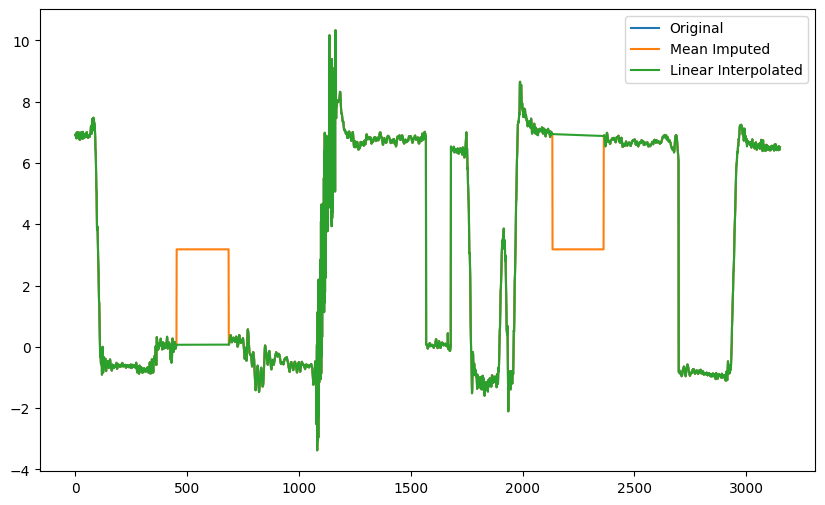

In [46]:

plt.figure(figsize=(10, 6))
plt.plot(x_axis , watch_acc[:, 0], label = 'Original')
plt.plot(x_axis, imputed_data, label = 'Mean Imputed')
plt.plot(x_axis , interpolated_data, label = 'Linear Interpolated')
plt.legend()

### Normalizing Data 

In [41]:

from sklearn.preprocessing import StandardScaler

### Scaling Data

In [39]:
tensor_inp = torch.tensor(train_dataset)
normalized = F.normalize(tensor_inp, dim=0)

In [98]:
train_data = train_dataset[6, : ,:]
# scaler = StandardScaler()
# scaler.fit(train_data)
# normalized = scaler.transform(train_data)

### Berkley Visualization

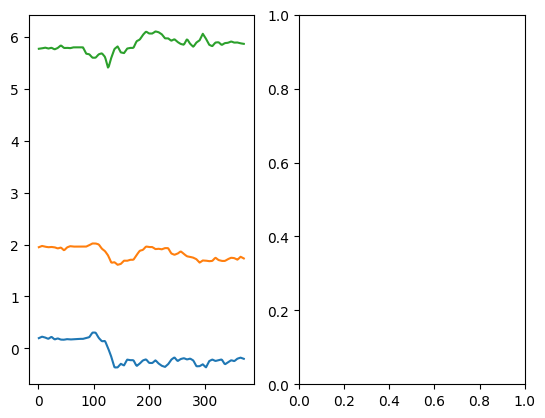

In [99]:
fig, axes = plt.subplots(nrows =1, ncols=2)
axes[0].plot(x, train_data)
# axes[1].plot(x, normalized, label='Interpolated')

### Data Distribution Visualization

In [77]:
values,count = np.unique(train_labels ,return_counts=True)

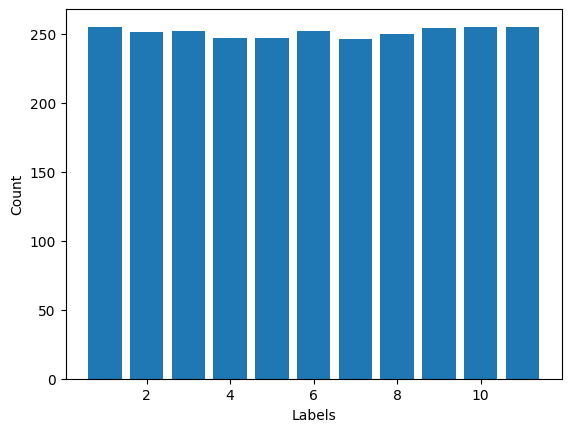

In [97]:
plt.bar(x = values,data = count, height = count)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

### Berkley Skeleton 

In [14]:
file_path = "/Users/tousif/Lstm_transformer/Fall_Detection_KD_Multimodal/data/sensor/SkeletalData/skl_s01_a01_r02.bvh"

In [15]:
with open(file=file_path, mode = 'r') as f:
    bvh_data = Bvh(f.read())

In [16]:
data = bvh_data.frames

In [17]:
skl_data = np.array(data)

In [21]:
seq_len = skl_data.shape[0]

In [27]:
xp = np.linspace(0, seq_len, num = seq_len)

In [28]:
x = np.linspace(0, seq_len, num = 600)

In [41]:
yp = skl_data[:,3]

In [42]:
new = np.interp(x, xp ,yp.astype(float))

In [72]:
numbers = [2, 3, 4]
product = multiply(*numbers)
print(product)  # Output: 24


NameError: name 'multiply' is not defined

In [66]:
bvh_data.get_joint()

TypeError: get_joint() missing 1 required positional argument: 'name'

### Visualizing Berkley Mhad Skeleton

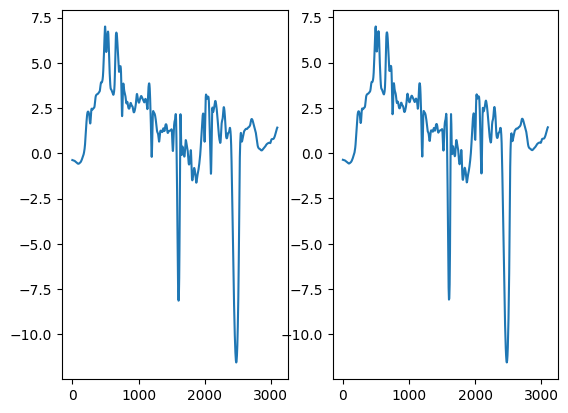

In [49]:
fig, axes = plt.subplots(nrows = 1 , ncols = 2)
axes[0].plot(xp, yp.astype(float))
axes[1].plot(x, new)
plt.show()